# Numerical Integration

In [176]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.integrate

## Exercies 14.1

In [111]:
def ex1func(g, a, b, N, method = 'trapezoid'):
    '''
    Function is capable of three numerical integration approximations,
    specified by method = 'midpoint', trapezoid', or 'Simpsons.' Other
    inputs are:
    g = function
    a, b = integration bounds
    N = fineness ('number of intervals')
    
    Details on methods found in the notes
    '''
    #Partition boundary
    partition = np.linspace(a, b, N)
    #initialize integral
    integral = 0
    if method == 'midpoint':
        for i in range(N-1):
            midpoint = (partition[i]+partition[i+1])/2
            integral += g(midpoint)
        integral = integral * ((b-a)/N)
    elif method == 'trapezoid':
        for i in range(1, N-1):
            integral += 2*g(partition[i])
        integral += g(partition[0]) + g(partition[N-1])
        integral = integral * (b-a)/(2*N)
    elif method == 'Simpsons':
        for i in range(N-1):
            midpoint = (partition[i]+partition[i+1])/2
            integral += ((partition[i+1] -partition[i])/6) * \
            (g(partition[i]) + 4*g(midpoint) + g(partition[i+1]))
    else:
        raise ValueError('method is invalid')
    return integral

In [112]:
#Testing:
g = lambda x: .1*x**4 - 1.5*x**3 + .53*x**2 + 2*x + 1
ex1func(g, -1, 1, 100, method='Simpsons')

2.393333333610939

## Exercise 14.2

In [87]:
import scipy.stats as sts

In [91]:
def normalapprox(mu, sigma, N, k):
    '''
    This function gives a discrete approximation of the distribution
    of the normal distribution with mean mu, std. deviation sigma. N 
    is the number of nodes, and k is the number of standard deviations 
    away from the mean that I consider.
    
    Returns Zvec a vector of nodes, and Wvec a vector of weights. 
    '''
    #define left and right bounds
    lbound = mu - sigma * k
    rbound = mu + sigma * k
    Zvec = np.linspace(lbound, rbound, N)
    #initialize weight vector
    Wvec = np.zeros_like(Zvec)
    for i in range(N):
        if i == 0:
            Wvec[i] = sts.norm.cdf((Zvec[i] + Zvec[i+1]) / 2, \
            loc=mu, scale=sigma)
        elif i == N-1:
            Wvec[i] = 1 - sts.norm.cdf((Zvec[i-1] + Zvec[i]) / 2, \
            loc=mu, scale=sigma)
        else:
            #Using midpoint method
            Wvec[i] = sts.norm.pdf(Zvec[i], loc=mu, scale=sigma) \
            * (rbound - lbound)/N
    return Zvec, Wvec

For N = 11, k = 4: 
 
 Nodes =  [-4.  -3.2 -2.4 -1.6 -0.8  0.   0.8  1.6  2.4  3.2  4. ]  
 
 Weights [1.59108590e-04 1.73388233e-03 1.62869311e-02 8.06696979e-02
 2.10684766e-01 2.90139840e-01 2.10684766e-01 8.06696979e-02
 1.62869311e-02 1.73388233e-03 1.59108590e-04] 
 
 A useful visualization:


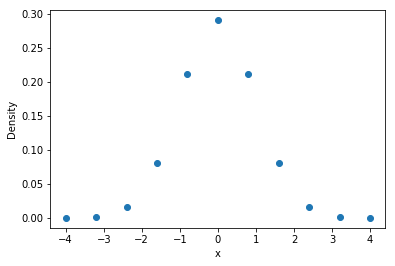

0.9092086115628059

In [95]:
#Test
Zvec, Wvec = normalapprox(0, 1, 11, 4)
plt.plot(Zvec, Wvec, 'o')
plt.xlabel('x')
plt.ylabel('Density')
print("For N = 11, k = 4: \n \n Nodes = ", Zvec, 
      " \n \n Weights", Wvec , \
      "\n \n A useful visualization:")
plt.show()

## Exercise 14.3

In [96]:
def lognormalapprox(mu, sigma, N, k):
    '''
    Function uses the normalapprox function to create a discrete 
    approximation for the lognormal distribution. Inputs/Outputs
    are interpreted similarly
    '''
    #Grab normal discrete approximation
    Zvecnorm, Wvecnorm = normalapprox(mu, sigma, N, k)
    #Transform node location while keeping weights same
    Zvec = np.exp(Zvecnorm)
    Wvec = Wvecnorm
    return Zvec, Wvec

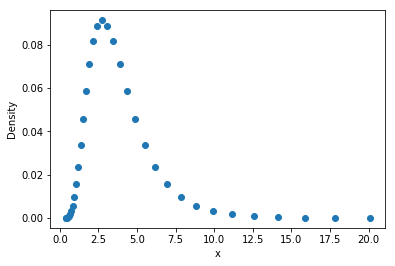

Looks pretty good!


0.9714351580624834

In [97]:
# Test by plotting
Zvec, Wvec = lognormalapprox(1, .5, 35, 4)
plt.plot(Zvec, Wvec, 'o')
plt.xlabel('x')
plt.ylabel('Density')
plt.show()
print("Looks pretty good!")

## Exercise 14.4

In [100]:
def expinc(mu, sigma, N, k):
    '''
    Uses above function to compute average U.S household income
    using the lognormalapprox function. Inputs are exactly the same,
    but now output is simply the expected income.
    '''
    Zvec, Wvec = lognormalapprox(mu, sigma, N, k)
    meaninc = np.average(Zvec, weights = Wvec)
    return meaninc

In [105]:
#Test
mu = 5
sigma = .5 
N = 100
k = 4

estval = expinc(mu, sigma, N, k)
trueval = np.exp(mu + (sigma**2)/2)

print(f"For N = {N}: \n Estimated val:", estval, "\n True val:", trueval )

For N = 100: 
 Estimated val: 168.170282681114 
 True val: 168.17414165184545


## Exercise 14.5

In [23]:
import scipy.optimize as opt

In [108]:
def error(params, args):
    '''
    Defines function which gives the left side - right side for the
    system of equations (14.11) for a given Ω, X, N, a, b.
    
    Ω, X are length N
    
    We'll want to set this = 0 and do a root-finder. 
    '''
    a, b, N = args
    Ω, X = params[:N], params[N:]
    left = np.zeros(2*N)
    right = np.zeros(2*N)
    # define left-side vector
    for i in range(2*N):
        left[i] = ( b ** (i+1) - a ** (i+1) ) / (i+1)
        right[i] = np.sum(Ω * np.power(X, i))
    err = np.abs(left-right)
    return err
        
def gaussquad(f, a, b, N, Ω_guess, X_guess):
    '''
    This function does gaussian quadrature using the class of polynomials x^i as 
    a basis. 
    
    I'll go ahead and extend the function to take arbitrary N. Arguments are:
    f = the function
    N = the number of weights/nodes
    a, b = integration limits
    Ω_guess = length-N initial guess for Ω
    X_guess = length-N initial guess for X
    See rick's chapter 14 page 194 for the system used to get nodes/weights
    
    Output is just the integral approximation
    '''
    #Grab params
    args = np.array([a, b, N])
    params_guess = (Ω_guess + X_guess)
    # I need to calculate the weights/nodes with a system of equations
    # Initialize vectors
    W = np.zeros(N)
    X = np.zeros(N)
    results = opt.fsolve(error, params_guess, args=args)
    Ω, X = results[:N], results[N:]
    #Calculate function approximation
    approx = np.sum(Ω * f(X))
    return approx

In [114]:
g = lambda x: .1*x**4 - 1.5*x**3 + .53*x**2 + 2*x + 1
Ω = [1, 1, 1]
X = [-.5, 0, .5]
a = -1
b = 1
N = 3

2.3933333333331515

In [115]:
print("The integral approximation is", gaussquad(g, a, b, N, Ω, X), "which is the correct value".)

The integral approximation is 2.3933333333331515 which is the correct value


## Exercise 14.6

In [121]:
result, error = sci.integrate.quad(g, -1, 1)
print("The approximated value", result, "is very close to the exact value" )

The approximated value 2.3933333333333335 is very close to the exact value


## Exercise 14.7

In [ ]:
def montecarlo(g, Ω, K):
    '''
    Function approximates itegrals using monte carlo integration (again)
    Inputs are 
    g is the function
    Ω is the domain: an Nx2 array with the limits of the box in the
    ith dimension as the ith row (this function only takes box domains)
    K the number of random draws
    
    Output is the monte carlo approximation to g
    '''
    #parse Ω for N the dimension
    N = Ω.shape[0]
    #Define volume of Ω
    vol = np.prod(Ω[:, 1] - Ω[:, 0])
    #simulate function K times
    integral = 0
    K = np.int(K)
    for i in range(K):
        #Modifications are to fit it into the correct domain
        randx = np.random.rand(N) * (Ω[:, 1] - Ω[:, 0]).T + Ω[:, 0].T
        integral += g(*randx)
    integral = vol * (1/K) * integral
    return integral

In [201]:
g = lambda x, y: int(x**2 + y**2 <= 1)
Ω = np.array([[-1, 1], [-1, 1]])
K = 100000
montecarlo(g, Ω, K)
print("It's hard to get a good approximation")

K is 100000
It's hard to get a good approximation


## Exercise 14.8

In [378]:
#function which gives M primes which tim found online
def primeslength(M):
    primes  = []
    number = 2
    while len(primes) < M:
        ptest    = [number for i in primes if number%i == 0]
        primes  += [] if ptest else [number]
        number += 1
    primes = np.array(primes)
    return primes

def equidist(d, n, kind = 'Weyl'):
    '''
    Function gives the nth element of a d-dimensional equidimensional
    sequence.
    
    Possible types are: 'Weyl', 'Haber', 'Niederreiter', 'Baker' 
    
    Output is n by d - a row is a sequence element.  
    Note - for large n, the creation of the primelist will be quite 
    computationally expensive.
    '''
    primelist = primeslength(d)
    equidseq = np.zeros((n, d))
    nlist = np.arange(1, n+1, 1)
    if kind == 'Weyl':
        mat = np.outer(nlist, np.sqrt(primelist))
    elif kind == 'Haber':
        mat = np.outer((nlist*(nlist + 1))/2, np.sqrt(primelist))
    elif kind =='Niederreiter':
        slist = np.linspace(1, d, d)
        S, N = np.meshgrid(slist, nlist)
        mat = N * (2 ** (S/(N+1)))
    elif kind == 'Baker':
        print("Not sure how to construct this - strange definition")
    else: 
        raise ValueError('kind must be Weyl, Haber, Niederreiter, Baker')
    equidseq = mat - np.floor(mat)
    return equidseq

[[0.41421356 0.        ]
 [0.5198421  0.1748021 ]
 [0.56762135 0.24264069]
 ...
 [0.69313812 0.38628585]
 [0.69313812 0.38628585]
 [0.69313812 0.38628585]]
I don't know how to do Baker.


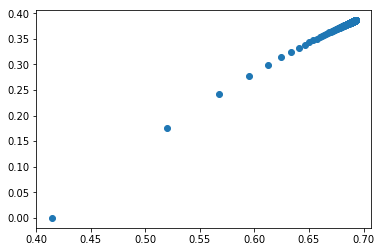

In [379]:
equidseq = equidist(2, 50000, kind = 'Niederreiter')
print(equidseq)
print("I don't know how to do Baker.")
plt.plot(equidseq[:, 0], equidseq[:, 1], 'o')

## Exercise 14.9

In [385]:
def montecarlo9(g, Ω, K):
    '''
    Function approximates itegrals using pseudo monte carlo integration (again)
    
    Inputs are 
    g is the function
    Ω is the domain: an Nx2 array with the limits of the box in the
    ith dimension as the ith row (this function only takes box domains)
    K the number of random draws
    
    I use weyl's pseudorandom sequence.
    
    Output is the monte carlo approximation to g using equidifferent sequences.
    '''
    #parse Ω for N the dimension
    N = Ω.shape[0]
    #Define volume of Ω
    vol = np.prod(Ω[:, 1] - Ω[:, 0])
    #simulate function K times
    integral = 0
    K = np.int(K)
    for i in range(K):
        #Modifications are to fit it into the correct domain
        randx = equidist(N, K)[i, :]
        integral += g(*randx)
    integral = vol * (1/K) * integral
    return integral

In [392]:
g = lambda x, y: int(x**2 + y**2 <= 1)
Ω = np.array([[-1, 1], [-1, 1]])
K = 10000
print(f"At K = {K}, pi approximates to {montecarlo9(g, Ω, K)} which is pretty good!")

At K = 10000, pi approximates to 3.1412 which is pretty good!
